> **Import Data**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# keras for machine learning tools
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import backend as k
from keras.layers import Input

# Tensorflow for neural nerwork model gradients
import tensorflow as tf

# Import plotting tools
import matplotlib.pyplot as plt

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# Import tools for visualizing random forest classification results
from sklearn.tree import export_graphviz
import pydot

# sklearn for splitting data into training and testing
from sklearn.model_selection import train_test_split

# scikit tool for support vector machines
from sklearn import svm

# sklearn for linear regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Set random seed
np.random.seed(0)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "IOWA-Congress115-CENSUS-DATA"]).decode("utf8"))


/home/james/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/james/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# -------------------------------------------------------------------------------- #
# ------------------------ Importing and Cleaning Data --------------------------- #
# -------------------------------------------------------------------------------- #


# ------------------------ Import US Census Data ---------------------------- #

# Import data
training_data = 'IOWA-Congress115-CENSUS-DATA/ACS_16_5YR_S0501_with_ann.csv'

# Create data frame of all data from congress since 2010
df_115_all = pd.read_csv(training_data, header=1)


# ------------------------ Cleaning US Census Data ---------------------------- #

# Remove first two columns of data set as they are not necessary for fitting data
df_115_all = df_115_all.drop(['Id', 'Id2'], axis=1)

# Create list of all header names
header_names = list(df_115_all.columns.values)

# Create empty list of header names for data we are going to remove
MoE_headers = [];

# Loop over header names and identify all headers with the string "Margin of Error"
for header in header_names:
    if "Margin of Error" in header:
        MoE_headers.append(header);
    
# Print list to check if it worked
#print(MoE_headers)

# Remove all elements from data set that correspond to Margin of Error in data as we will not be using them for training
df_115 = df_115_all.drop(MoE_headers,axis=1)

# Preview updated data frame
#df_115.head()

# Create a list of all features
feature_list = list(df_115)

# Print list of feautres
#print(feature_list)

# Combining testing and training data to begin cleaning process
df_all = df_115

# Print shape of data frame containing all data
#print("Train shape:", df_all.shape)

# Check if data frame contains any null values
#df_all.isnull().values.any()


# ---------------------- Encode Categorical Features as Numerical ------------------ #

# Add new column for Congress Number
df_all['Congress Number'] = 0;

# Loop over all rows of data frame to update 'Congress Number' value in df_all
for i in range(df_all.shape[0]):
    for j in range(108,116):
        # Set mystr to Congress Number + th (e.g. 115th)
        mystr = str(j) + 'th';
        # Check if Congress Number appears in Geography in df_all
        if mystr in df_all.loc[i,'Geography']:
            # Update 'Congress Number' value to j in df_all
            df_all.loc[i,'Congress Number'] = j;
            break;
            
# Preview updated data frame
#df_all.head()



# --------------------- Encode Geographical Information ---------------------------- #

# Add new column for State
list_of_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
                  'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
                  'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
                  'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
                  'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
                  'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
                  'Wisconsin', 'Wyoming'];

# Create dictionary for list of states where keys are state names and values are indices (starting with 0)
states_dict = dict(zip(list_of_states, range(50)))

# Initialize 'State' values in data frame all to 0
df_all['State'] = 0;

# Loop over all rows of data frame to update 'Congress Number' value in df_all
for i in range(df_all.shape[0]):
    for state in list_of_states:
        # Check if State name appears in Geography in df_all
        if state in df_all.loc[i,'Geography']:
            # Update 'State' value to state in df_all
            df_all.loc[i,'State'] = states_dict[state];
            break;
            
# Create column for 'Congressional District'
df_all['Congressional District'] = 0;

# Update value of 'Congressional District' for each entry
for i in range(df_all.shape[0]):
    for j in range(1,5):
        # Set mystr to 'District j'
        mystr = 'District ' + str(j);
        # Set checkstr to Current Congressional District in data frame
        checkstr = str(df_all.loc[i,'Geography']);
        # Check if Congress Number appears in Geography in df_all
        if mystr in checkstr:
            # Update 'Congress Number' value to j in df_all
            df_all.loc[i,'Congressional District'] = int(j);
            break;

# Drop the Geography column now that all information has been extracted
df_all.drop(['Geography'], axis=1, inplace = True)


# ------------------- Create shorter version of the data (only age, gender, race, education) ------------------ #

# Copy data frame to make shorter version of data
df_short = df_all.copy()

# Create list of header names for df_fl
iowa_header_names = list(df_short.columns.values)

# Create empty list of header names for data we are going to remove
CENSUS_headers = [];

# Headers to drop (everything excluding gender, age, race, education, and median household income)
drop_headers = ['HOUSEHOLD TYPE', 'MARITAL STATUS', 'LANGUAGE SPOKEN AT HOME', 'EMPLOYMENT STATUS', 
                'OCCUPATION', 'INDUSTRY', 'EARNINGS IN THE PAST 12 MONTHS', 'INCOME IN THE PAST 12 MONTHS', 
                'POVERTY STATUS IN THE PAST 12 MONTHS', 'POVERTY RATES FOR FAMILIES', 'ROOMS', 
                'VEHICLES AVAILABLE', 'SELECTED CHARACTERISTICS', 'SELECTED MONTHLY OWNER COSTS', 
                'GROSS RENT AS A PERCENTAGE', 'Owner-occupied housing units', 'occupants per room',
                'Median number of rooms', 'Average household size', 'HOUSING TENURE', 'ccupied housing units',
                'Average number of workers', 'Median earnings (dollars)', 'CLASS OF WORKER', 
                'Civilian employed population 16 years and over', 'Average family size']

# Loop over header names and identify all headers containing any string in drop_headers
for header in iowa_header_names:
    for drop in drop_headers:
        if drop in header:
            CENSUS_headers.append(header);
            break;
    
# Print list to check if it worked
#print(CENSUS_headers)

# Remove all elements from data set that do not correspond to age, gender, race, education, or median income
df_short = df_short.drop(CENSUS_headers, axis=1)
# Preview data
#df_short.head()


# --------------- Convert percentages in data frame to decimals ---------------- #

# Create data frame which has percentages instead of raw population numbers
df_short_p = df_short.copy()

# Create list of headers with values representing percentages
iowa_raw_header_list = list(df_short_p.columns.values)

# List of headers to exclude as they do not correspond to percentage values
drop_list = ['Total; Estimate; Total population', 'Native; Estimate; Total population', 
             'Foreign born; Estimate; Total population', 
             'Foreign born; Naturalized citizen; Estimate; Total population', 
             'Foreign born; Not a U.S. citizen; Estimate; Total population',
             'Total; Estimate; Median Household income (dollars)', 
             'Native; Estimate; Median Household income (dollars)', 
             'Foreign born; Estimate; Median Household income (dollars)', 
             'Foreign born; Naturalized citizen; Estimate; Median Household income (dollars)', 
             'Foreign born; Not a U.S. citizen; Estimate; Median Household income (dollars)', 
             'Congress Number', 'State','Congressional District']

# List of headers of df_fl with values representing percentages
percentage_list = [i for i in iowa_raw_header_list if i not in drop_list]

# Create list of header types used in converting percentages to raw population values
header_types = ['Total; Estimate;', 'Native; Estimate;', 'Foreign born; Estimate;', 
                'Foreign born; Naturalized citizen; Estimate;', 'Foreign born; Not a U.S. citizen; Estimate;']

# Convert each value from percentage to decimal
for mystr in percentage_list:
    for header in header_types:
        if header in mystr:
            # Convert percentage to value
            df_short_p[mystr] = df_short_p[mystr] / 100
            break;

# Additional features to drop as they are not required for training
additional_drop_types = ['SCHOOL ENROLLMENT - Population 3 years and over enrolled in school', 
                         'EDUCATIONAL ATTAINMENT - Population 25 years and over']

# Drop additional features
for mystr in additional_drop_types:
    for header in header_types:
        # Initialize header of feature to drop
        totalstr = header + ' ' + mystr
        # Drop feature from data frame
        df_short_p.drop([totalstr], axis = 1, inplace = True)
            
# Preview data            
df_short_p.head()


# Choose data to use in remainder of cleaning process (if using all data comment out next line)
df_all = df_short_p.copy()

# If using df_all instead of df_short_p for data the following two lines should not be commented out (contain NaNs)
#df_all.drop(['Foreign born; Not a U.S. citizen; Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Armed Forces'], axis = 1, inplace=True)
#df_all.drop(['Foreign born; Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Armed Forces'], axis = 1, inplace=True)



# --------------------- Import Voter Information Data -------------------- #

# Initialize list of names of data frames
df_voters_names = [];

# Create data frame containing voter registration data for all election data
for i in [2010, 2012, 2014, 2016]:
    # Update name to use for data frame
    df_name = 'dfVoters' + str(i);
    # Update list of names of data frames
    df_voters_names.append(df_name)
    # Update name of data file to import
    data_file_name = 'IOWA-VoterRegistration-District-DATA/IOWA-VoterRegistrtion-District-DATA-' + str(i) + '.csv'
    # Create data frame with name 'dfVoters' + str(i)
    locals()[df_name] = pd.read_csv(data_file_name)
    # Drop 'District' column from voters data frame and append to census data
    locals()[df_name].drop(['District'], axis = 1, inplace = True)
    # Rename some columns in voters data frame
    locals()[df_name].rename(columns = {'Democratic Active':'Active Democrat Voters', 
                                        'Rebuplican Active':'Active Republican Voters',
                                        'No Party Active':'Active Voters with No Party'}, inplace = True)
    # Merge voter data with data from census
    locals()[df_name] = pd.concat([locals()[df_name], df_all], axis = 1)
    
# Create dictionary for new data frame names
voters_names_dict = dict(zip([2010, 2012, 2014, 2016], df_voters_names))

# Display the data from one of the years
locals()[voters_names_dict[2014]].head()

# Initialize list of party names
party_names = ['Republican', 'Democrat']
party_dict = dict(zip(range(2), party_names))



# --------------------------- Import Candidate Data -------------------------- #

# Initialize empty data frames to contain all candidate data from 2010 to 2016
df_names = []

for i in [2010, 2012, 2014, 2016]:
    # Update name to use for data frame
    df_name = 'dfFeatures' + str(i);
    # Update list of names of data frames
    df_names.append(df_name)
    # Create data frame with name 'dfVoters' + str(i)
    locals()[df_name] = pd.DataFrame()

# Create dictionary
df_features_dict = dict(zip([2010, 2012, 2014, 2016], df_names))

# Create data frame containing voter registration data for all election data
for i in [2012, 2014, 2016]:
    # Update list of names of data frames
    df_voters_names.append(df_name)
    # Update name of data file to import
    data_file_name = 'IOWA-ElectionSpending-Outcome-DATA/IOWA-ElectionSpending-Outcome-DATA-' + str(i) + '.csv'
    # Create temporary data frame df_temp
    df_year = pd.read_csv(data_file_name)
    # Drop 'Elected Party' and 'District' from df_temp
    df_year.drop(['Elected Party', 'District'], axis = 1, inplace = True)
    # Create column for 'Party'
    df_year['Candidate Party'] = 0
    # Create column for 'Year of Election'
    df_year['Year of Election'] = i
    # Update header names to reflect which candidate data supports
    for j in range(2):
        # Set df_temp to df_year
        df_temp = df_year.copy()
        # Set party to party name
        party = party_dict[j]
        # Rename 'Party' entries so they reflect which party the data pertains to
        df_temp['Candidate Party'] = party
        # Reset indices of df_temp and voters_names_dict[i] before concatenating to avoid creating NaNs
        df_temp.reset_index(drop=True,inplace=True)
        locals()[voters_names_dict[i]].reset_index(drop=True,inplace=True)
        # Merge df_temp with census and voter data by column
        df_temp = pd.concat([df_temp, locals()[voters_names_dict[i]]], axis = 1)
        # Merge voter data with data from census by row
        locals()[df_features_dict[i]] = pd.concat([locals()[df_features_dict[i]], df_temp])

locals()[df_features_dict[2014]].head(8)

# Initialize empty data frames to contain all candidate data from 2010 to 2016
df_names = []

for i in [2010, 2012, 2014, 2016]:
    # Update name to use for data frame
    df_name = 'dfTarget' + str(i);
    # Update list of names of data frames
    df_names.append(df_name)
    # Create data frame with name 'dfVoters' + str(i)
    locals()[df_name] = pd.DataFrame()
    
# Create dictionary
df_target_dict = dict(zip([2010, 2012, 2014, 2016], df_names))

# Create data frame containing target election results for all elections
for i in [2010, 2012, 2014, 2016]:
    # Update list of names of data frames
    df_voters_names.append(df_name)
    # Update name of data file to import
    data_file_name = 'IOWA-Votes-DATA/IOWA-Votes-DATA-' + str(i) + '.csv'
    # Create temporary data frame df_temp
    df_year = pd.read_csv(data_file_name)
    # Update header names to reflect which candidate data supports
    for j in range(2):
        # Set party to party name
        party = party_dict[j]
        # Set string to column of interest
        columnstr = 'Percentage of Votes for ' + party + ' Candidate'
        # Set df_temp to df_year
        df_temp = df_year[columnstr]
        # Rename columnstr to 'Percentage of Votes'
        df_temp.rename(columns = {columnstr:'Percentage of Votes (Republican then Democrat)'}, inplace = True)
        # Reset indices of df_temp before concatenating to avoid creating NaNs
        df_temp.reset_index(drop=True,inplace=True)
        # Merge target data with all targets for year
        locals()[df_target_dict[i]] = pd.concat([locals()[df_target_dict[i]], df_temp])
    # Create column for 'Year of Election'
    locals()[df_target_dict[i]]['Year of Election'] = i
    # Rename columnstr to 'Percentage of Votes'
    locals()[df_target_dict[i]].rename(columns = {0:'Percentage of Votes (Republican then Democrat)'}, inplace = True)


    
# -------------------- Data Frames for Features and Target ------------------------- #

# Initialize data frames 
df_features = pd.DataFrame()
df_targets = pd.DataFrame()

# Create feature and target data frames
for i in [2012, 2014, 2016]:
    df_features = pd.concat([df_features, locals()[df_features_dict[i]]])
    df_targets = pd.concat([df_targets, locals()[df_target_dict[i]]])
    
# Display all features and targets for elections from 2012, 2014, and 2016
#df_features.head(24)
#df_targets.head(24)

In [3]:
# ----------- Configure data for modeling the percentage of votes earned using neural network ------------ #
# Create data frame of features and targets
df_complete = pd.concat([df_features.drop(['Year of Election', 'State', 'Congressional District', 'Congress Number'], axis = 1), 
                         df_targets.drop(['Year of Election'], axis = 1)], axis = 1)

df_complete['Party in Office'] = df_complete['Party in Office'].replace(party_names, range(2))
df_complete['Incumbent Republican Candidate Running'] = df_complete['Incumbent Republican Candidate Running'].replace({'No','Yes'}, range(2))
df_complete['Incumbent Democrat Candidate Running'] = df_complete['Incumbent Democrat Candidate Running'].replace({'No','Yes'}, range(2))


# ----------------------- Convert raw population values to percentages --------------------- #
pop_list = ['Active Democrat Voters', 'Active Republican Voters', 'Active Voters with No Party',
            'Native; Estimate; Total population', 
            'Foreign born; Estimate; Total population', 
            'Foreign born; Naturalized citizen; Estimate; Total population', 
            'Foreign born; Not a U.S. citizen; Estimate; Total population']

# Initialize string for data frame column containing total population values per district
totalpopstr = 'Total; Estimate; Total population'

for mystr in pop_list:
    # Convert population to percentage of population in the district
    df_complete[mystr] = df_complete[mystr] / df_complete[totalpopstr]
    
# Drop total percentage as it is not needed anymore
df_complete.drop([totalpopstr], axis = 1, inplace = True)


# ------------------ Convert median income values to percentages of $100000 ---------------- #
income_list = ['Total; Estimate; Median Household income (dollars)', 
               'Native; Estimate; Median Household income (dollars)', 
               'Foreign born; Estimate; Median Household income (dollars)', 
               'Foreign born; Naturalized citizen; Estimate; Median Household income (dollars)', 
               'Foreign born; Not a U.S. citizen; Estimate; Median Household income (dollars)']

for mystr in income_list:
    # Convert population to percentage of population in the district
    df_complete[mystr] = df_complete[mystr] / 100000


# --------------- Convert campaign spending values to percentages of $4million ------------- #
df_complete['Republican Candidate Spending'] = df_complete['Republican Candidate Spending'] / 4000000
df_complete['Democrat Candidate Spending'] = df_complete['Democrat Candidate Spending'] / 4000000
    
    
# ---------------- Create data frames for Republicans and for Democrats -------------------- #
# Republican dataframe
df_republican = df_complete.copy()
df_republican.reset_index(drop=True,inplace=True)
# Democrat dataframe
df_democrat = df_complete.copy()
df_democrat.reset_index(drop=True,inplace=True)

# Initialize republican and democrat index drop lists
repub_drop_list = []
dem_drop_list = []

for i in range(df_complete.shape[0]):
    if 'Republican' != df_republican.iloc[i, 5]:
        repub_drop_list.append(i)
    if 'Democrat' != df_democrat.iloc[i, 5]:
        dem_drop_list.append(i)

df_republican.drop(repub_drop_list, inplace = True)
df_democrat.drop(dem_drop_list, inplace = True)

# Convert categorical features to nominal
df_complete['Candidate Party'] = df_complete['Candidate Party'].replace(party_names, range(2))
df_republican['Candidate Party'] = df_republican['Candidate Party'].replace(party_names, range(2))
df_democrat['Candidate Party'] = df_democrat['Candidate Party'].replace(party_names, range(2))

In [4]:
# Save data frames to csv files
#df_complete.to_csv(path_or_buf='CleanData/CompleteIOWA.csv')
#df_republican.to_csv(path_or_buf='CleanData/RepublicanIOWA.csv')
#df_democrat.to_csv(path_or_buf='CleanData/DemocratIOWA.csv')

# Option to print all columns and rows in data frame (used to look for values that were creating trouble in neural network)
#with pd.option_context('display.max_rows', None, 'display.max_columns', 183):
#    print(df_complete)

df_complete.head(25)

,Republican Candidate Spending,Democrat Candidate Spending,Party in Office,Incumbent Republican Candidate Running,Incumbent Democrat Candidate Running,Candidate Party,Active Democrat Voters,Active Republican Voters,Active Voters with No Party,Native; Estimate; Total population,...,Native; Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree,Foreign born; Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree,Foreign born; Naturalized citizen; Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree,Foreign born; Not a U.S. citizen; Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over - Graduate or professional degree,Total; Estimate; Median Household income (dollars),Native; Estimate; Median Household income (dollars),Foreign born; Estimate; Median Household income (dollars),Foreign born; Naturalized citizen; Estimate; Median Household income (dollars),Foreign born; Not a U.S. citizen; Estimate; Median Household income (dollars),Percentage of Votes (Republican then Democrat)
0,0.268431,0.666110,1,1,0,0,0.207355,0.177888,0.237359,0.964498,...,0.078,0.153,0.164,0.145,0.55366,0.55464,0.52726,0.56463,0.49906,41.6
1,0.241927,0.386140,1,1,0,0,0.218274,0.180564,0.225664,0.953078,...,0.094,0.220,0.190,0.240,0.52126,0.52287,0.47850,0.55334,0.42676,42.5
2,0.970576,0.441609,0,0,0,0,0.191425,0.205517,0.182577,0.935349,...,0.095,0.098,0.107,0.091,0.60261,0.60881,0.50906,0.54080,0.46976,52.3
3,0.953941,0.838987,0,0,1,0,0.169728,0.237559,0.225191,0.953093,...,0.068,0.138,0.126,0.145,0.51111,0.51594,0.41223,0.51183,0.36257,53.0
0,0.268431,0.666110,1,1,0,1,0.207355,0.177888,0.237359,0.964498,...,0.078,0.153,0.164,0.145,0.55366,0.55464,0.52726,0.56463,0.49906,56.9
1,0.241927,0.386140,1,1,0,1,0.218274,0.180564,0.225664,0.953078,...,0.094,0.220,0.190,0.240,0.52126,0.52287,0.47850,0.55334,0.42676,55.6
2,0.970576,0.441609,0,0,0,1,0.191425,0.205517,0.182577,0.935349,...,0.095,0.098,0.107,0.091,0.60261,0.60881,0.50906,0.54080,0.46976,43.7
3,0.953941,0.838987,0,0,1,1,0.169728,0.237559,0.225191,0.953093,...,0.068,0.138,0.126,0.145,0.51111,0.51594,0.41223,0.51183,0.36257,44.9
0,0.257867,0.354208,1,1,1,0,0.204041,0.175069,0.244802,0.964498,...,0.078,0.153,0.164,0.145,0.55366,0.55464,0.52726,0.56463,0.49906,51.1
1,0.235123,0.430434,1,1,0,0,0.214358,0.179465,0.235117,0.953078,...,0.094,0.220,0.190,0.240,0.52126,0.52287,0.47850,0.55334,0.42676,47.4


In [5]:
# Split data into training and testing sets for cross validation
train_data, test_data = train_test_split(df_complete, test_size=0.1)
train_repub, test_repub = train_test_split(df_republican, test_size=0.1)
train_dem, test_dem = train_test_split(df_democrat, test_size=0.1)

# View info on training and testing sets
print("------ Training Data Information ------")
train_data.info()

print("\n\n------ Testing Data Information ------")
test_data.info()

# ----- Format input and target data for age classification as numpy matrices -----
# Create numpy matricies for training data
X_train = train_data.drop(['Percentage of Votes (Republican then Democrat)'], axis=1).values
Y_train = train_data[['Percentage of Votes (Republican then Democrat)']].values
X_repub = train_repub.drop(['Percentage of Votes (Republican then Democrat)'], axis=1).values
Y_repub = train_repub[['Percentage of Votes (Republican then Democrat)']].values
X_dem = train_dem.drop(['Percentage of Votes (Republican then Democrat)'], axis=1).values
Y_dem = train_dem[['Percentage of Votes (Republican then Democrat)']].values

# Create numpy matricies for testing data
X_test = test_data.drop(['Percentage of Votes (Republican then Democrat)'], axis=1).values
Y_test = test_data[['Percentage of Votes (Republican then Democrat)']].values
X_test_repub = test_repub.drop(['Percentage of Votes (Republican then Democrat)'], axis=1).values
Y_test_repub = test_repub[['Percentage of Votes (Republican then Democrat)']].values
X_test_dem = test_dem.drop(['Percentage of Votes (Republican then Democrat)'], axis=1).values
Y_test_dem = test_dem[['Percentage of Votes (Republican then Democrat)']].values

# Update shape of Y_train and Y_test
Y_train = Y_train.reshape(Y_train.size,)
Y_test = Y_test.reshape(Y_test.size,)
Y_repub = Y_repub.reshape(Y_repub.size,)
Y_test_repub = Y_test_repub.reshape(Y_test_repub.size,)
Y_dem = Y_dem.reshape(Y_dem.size,)
Y_test_dem = Y_test_dem.reshape(Y_test_dem.size,)

# Divide Y_train and Y_test by 100 to get values between 0 and 1
Y_train = Y_train/100
Y_test = Y_test/100
Y_repub = Y_repub/100
Y_test_repub = Y_test_repub/100
Y_dem = Y_dem/100
Y_test_dem = Y_test_dem/100

# Confirming that the shape of the training matrices are correct
print("\n\nShape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)

# Confirming that the shape of the testing matrices are correct
print("\n\nShape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

------ Training Data Information ------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 2 to 0
Columns: 174 entries, Republican Candidate Spending to Percentage of Votes (Republican then Democrat)
dtypes: float64(170), int64(4)
memory usage: 28.7 KB


------ Testing Data Information ------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 3 to 2
Columns: 174 entries, Republican Candidate Spending to Percentage of Votes (Republican then Democrat)
dtypes: float64(170), int64(4)
memory usage: 4.1 KB


Shape of X_train:  (21, 173)
Shape of Y_train:  (21,)


Shape of X_test:  (3, 173)
Shape of Y_test:  (3,)


In [6]:
# Initialize number of features
n_features = X_train.shape[1]

# Check feature matrices for NaN
print("Checking X_train for NaNs")
for i in range(n_features):
    if np.isnan(X_train.T[i]).any():
        print("NaN in column:", i)

print("Checking X_test for NaNs")
for i in range(n_features):
    if np.isnan(X_test.T[i]).any():
        print("NaN in column:", i)
        
print("Checking X_repub for NaNs")
for i in range(n_features):
    if np.isnan(X_repub.T[i]).any():
        print("NaN in column:", i)
        
print("Checking X_test_repub for NaNs")
for i in range(n_features):
    if np.isnan(X_test_repub.T[i]).any():
        print("NaN in column:", i)

Checking X_train for NaNs
Checking X_test for NaNs
Checking X_repub for NaNs
Checking X_test_repub for NaNs


# Neural Network Classifier

In [23]:
# ----------- Predicting percentage of votes earned by each candidate ------------ #
n_primary = 8
n_features = n_primary

# Create sequential model for neural network
nnet_model = Sequential()

# ----- Add first layer of network (Input layer) -----
# Number of neurons:   n_features
# Number of inputs:    n_features (the number of features)
# Activation layer:  ReLU (Rectified Linear Unit)
# 'Dense' refers to the fact that the layer is totally connected
nnet_model.add(Dense(n_features, input_dim=n_features, activation='relu'))

# ----- Add second layer of network (Hidden layer) -----
# Number of neurons:  n_features/2
# Number of inputs:   n_features (this is automatically determined since the model type is 'Sequential')
# Activation layer:  ReLU (Rectified Linear Unit)
#nnet_model.add(Dense(int(n_features/2), activation='relu'))

# ----- Add final layer of network (Output layer) -----
# Number of neurons:       1
# Number of inputs:      n_features/2 (this is automatically determined since the model type is 'Sequential')
# Activation layer:  Sigmoid (This ensures out output is between 0 and 1 for classification)
nnet_model.add(Dense(1, activation='sigmoid'))

# Compile the neural network model
# Loss function:        Mean Squared Error
# Gradient Descent algorithm:     adam (More on adam here: https://arxiv.org/abs/1412.6980)
# Classification metric:      accuracy
nnet_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


# ----------- Binary Classification of which party will win ------------ #
# Create sequential model for neural network
bin_model = Sequential()

# ----- Add first layer of network (Input layer) -----
# Number of neurons:   n_features
# Number of inputs:    n_features (the number of features)
# Activation layer:  ReLU (Rectified Linear Unit)
# 'Dense' refers to the fact that the layer is totally connected
bin_model.add(Dense(n_features, input_dim=n_features, activation='relu'))

# ----- Add second layer of network (Hidden layer) -----
# Number of neurons:  n_features/2
# Number of inputs:   n_features (this is automatically determined since the model type is 'Sequential')
# Activation layer:  ReLU (Rectified Linear Unit)
bin_model.add(Dense(int(n_features/2), activation='relu'))

# ----- Add final layer of network (Output layer) -----
# Number of neurons:     2 (num_classes)
# Number of inputs:      n_features/2 (this is automatically determined since the model type is 'Sequential')
# Activation layer:  Sigmoid (This ensures out output is between 0 and 1 for classification)
bin_model.add(Dense(2, activation='sigmoid'))

# Compile the neural network model
# Loss function:      Mean Squared Error
# Gradient Descent algorithm:     adam (More on adam here: https://arxiv.org/abs/1412.6980)
# Classification metric:      accuracy
bin_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
# Initialize inputs
X1 = X_train[:,0:n_primary]
X2 = X_train[:,n_primary:X_train.shape[1]]
X1_test = X_test[:,0:n_primary]
X2_test = X_test[:,n_primary:X_train.shape[1]]


# Fit the two different models using the training data
# --- Model 1: Predict number of votes for candidate --- #
nnet_model.reset_states();
nnet_model.fit(X1, Y_train, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#obj_model.save('Keras-Models/obj_model.h5')

# Print Predictions on Testing Data
print("----------------------- Testing Scenarios -----------------------")
for i in range(3):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X1_test)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test[i]))
    print("\n")
    
# Print Predictions on Training Data
print("----------------------- Training Scenarios -----------------------")
for i in range(21):
    print("--------------- Training Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X1)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_train[i]))
    print("\n")

----------------------- Testing Scenarios -----------------------
--------------- Testing Scenario 0 ---------------
 Percentage of votes earned (predictions): 54.05
 Actual Percentage of votes earned:        61.60


--------------- Testing Scenario 1 ---------------
 Percentage of votes earned (predictions): 53.49
 Actual Percentage of votes earned:        52.80


--------------- Testing Scenario 2 ---------------
 Percentage of votes earned (predictions): 42.96
 Actual Percentage of votes earned:        39.70


----------------------- Training Scenarios -----------------------
--------------- Training Scenario 0 ---------------
 Percentage of votes earned (predictions): 46.13
 Actual Percentage of votes earned:        42.20


--------------- Training Scenario 1 ---------------
 Percentage of votes earned (predictions): 43.36
 Actual Percentage of votes earned:        46.10


--------------- Training Scenario 2 ---------------
 Percentage of votes earned (predictions): 46.82
 Actual P

In [25]:
#X_scens = np.load('Numpy-Array-Files/Input_scenarios.npy')

#print(X_scens[0][0])

#print(X_train[0])

# Function for determining derivative of neural network objective function
# Initialize output tensor for Democratic neural network model
DemOutputTensor = nnet_model.output

# List of output variables for Tensor
DemVars = nnet_model.inputs
#print(DemVars)

# Compute Gradients
DemGradients = k.gradients(DemOutputTensor, DemVars)
#print(DemGradients)

# Evaluate Gradients
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(10):
    eval_gradients = sess.run(DemGradients, feed_dict={nnet_model.input: X1[i].reshape(1,n_features)})
    print(eval_gradients[0])
    print(Y_train[i])
    print('\n')
# Extract derivatives of objective with respect to Democratic and Republican Spending
repub_spending_derivative = eval_gradients[0][0][0]
dem_spending_derivative = eval_gradients[0][0][1]

# Print Gradient Values
print(dem_spending_derivative)
print(repub_spending_derivative)
print(eval_gradients[0])

[[-0.0090296   0.08766784 -0.030916    0.01889744 -0.00811908 -0.03168951
   0.12067287  0.07277603]]
0.42200000000000004


[[ 0.03914244  0.13182864 -0.01090739  0.01378188  0.06114336 -0.09869216
   0.054612    0.08432113]]
0.461


[[-0.02333102  0.12201075 -0.06005579  0.02415325  0.02558592 -0.00863623
   0.11625964  0.02860175]]
0.425


[[-0.00846339  0.03388285  0.03152125 -0.03065927 -0.01269707  0.00575007
   0.05635996  0.0170525 ]]
0.525


[[ 0.07994018  0.12194674  0.08748371 -0.00283517  0.02401215 -0.05396702
  -0.02932998  0.10805418]]
0.386


[[ 0.03449932  0.11619098 -0.00961353  0.01214706  0.05389047 -0.08698519
   0.04813385  0.07431886]]
0.537


[[-0.04835493  0.15708041 -0.03848288 -0.07087936  0.10831986 -0.09184195
   0.06727561  0.02884367]]
0.511


[[-0.00911574  0.08850416 -0.03121092  0.01907771 -0.00819653 -0.03199181
   0.12182404  0.07347029]]
0.43700000000000006


[[-0.02343521  0.12255561 -0.06032398  0.02426111  0.02570018 -0.00867479
   0.11677883  0.0

In [177]:
# ----------- Predicting percentage of votes earned by each candidate ------------ #
# Create sequential model for neural network
obj_model = Sequential()

# ----- Add first layer of network (Input layer) -----
# Number of neurons:   n_features
# Number of inputs:    n_features (the number of features)
# Activation layer:  ReLU (Rectified Linear Unit)
# 'Dense' refers to the fact that the layer is totally connected
obj_model.add(Dense(n_primary, input_dim=n_primary, activation='relu'))

# ----- Add second layer of network (Hidden layer) -----
# Number of neurons:  n_features/2
# Number of inputs:   n_features (this is automatically determined since the model type is 'Sequential')
# Activation layer:  ReLU (Rectified Linear Unit)
#nnet_model.add(Dense(int(n_features/2), activation='relu'))

# ----- Add final layer of network (Output layer) -----
# Number of neurons:       1
# Number of inputs:      n_features/2 (this is automatically determined since the model type is 'Sequential')
# Activation layer:  Sigmoid (This ensures out output is between 0 and 1 for classification)
obj_model.add(Dense(1, activation='sigmoid'))

# Compile the neural network model
# Loss function:        Mean Squared Error
# Gradient Descent algorithm:     adam (More on adam here: https://arxiv.org/abs/1412.6980)
# Classification metric:      accuracy
obj_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Initialize inputs
X1 = X_train[:,0:6]
X1_test = X_train[:,0:6]

# Fit the two different models using the training data
# --- Model 1: Predict number of votes for candidate --- #
obj_model.reset_states();
obj_model.fit(X1, Y_train, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#obj_model.save('Keras-Models/obj_model.h5')

# Print Predictions on Testing Data
print("----------------------- Testing Scenarios -----------------------")
for i in range(3):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*obj_model.predict([X1,X2])[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test[i]))
    print("\n")
    
# Print Predictions on Training Data
print("----------------------- Training Scenarios -----------------------")
for i in range(21):
    print("--------------- Training Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*obj_model.predict([X1,X2])[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_train[i]))
    print("\n")

In [96]:
# ----------- Predicting percentage of votes earned by each candidate (emphasis on campaign spending) ------------ #
# Create sequential model for neural network

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
secondary_input = Input(shape=(n_features - 2,), name='secondary_input')

# Convert secondary input into single real number
#x1 = Dense(output_dim = 1, input_dim = n_features - 2)(secondary_input)

# Reduce dimension of secondary input
#x2 = Dense(int(n_features/2), activation='relu', input_dim = n_features - 2, name='x2')(secondary_input)

# Output secondary information so it can be trained with entire network
secondary_output = Dense(10, activation='relu', name='secondary_output')(secondary_input) #(x2)

# Initialize primary inputs for model containing campaign expendetures
primary_input = Input(shape=(2,), name='primary_input')

# Concatenate primary input with preprocessed seconday inputs
x = keras.layers.concatenate([primary_input, secondary_output])

# We stack a deep densely-connected network on top
x = Dense(3, activation='relu')(x)
#x = Dense(3, activation='relu')(x)
#x = Dense(3, activation='relu')(x)
#x = Dense(1, activation='sigmoid')(x)

# And finally we add the main logistic regression layer
primary_output = Dense(1, activation='sigmoid', name='primary_output')(x)

# Define model
obj_model = Model(inputs=[primary_input, secondary_input], outputs=[primary_output])

# Compile model
obj_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

In [190]:
# ----------- Predicting percentage of votes earned by each candidate (emphasis on campaign spending) ------------ #
# Number of features in primary_input
n_primary = 6
n_encoded = 2

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
secondary_input = Input(shape=(n_features - n_primary,), name='secondary_input')

# Convert secondary input into single real number
#x1 = Dense(output_dim = 1, input_dim = n_features - 2)(secondary_input)

# Reduce dimension of secondary input
#x2 = Dense(int(n_features/2), activation='relu', input_dim = n_features - 2, name='x2')(secondary_input)

# Output secondary information so it can be trained with entire network
secondary_output = Dense(2, activation='relu', name='secondary_output')(secondary_input) #(x2)

# Initialize primary inputs for model containing campaign expendetures
primary_input = Input(shape=(n_primary,), name='primary_input')

# Concatenate primary input with preprocessed seconday inputs
x = keras.layers.concatenate([primary_input, secondary_output])

# We stack a deep densely-connected network on top
x = Dense(n_primary + n_encoded, activation='relu')(x)
#x = Dense(3, activation='relu')(x)
#x = Dense(3, activation='relu')(x)
#x = Dense(1, activation='sigmoid')(x)

# And finally we add the main logistic regression layer
primary_output = Dense(1, activation='sigmoid', name='primary_output')(x)

# Define model
obj_model = Model(inputs=[primary_input, secondary_input], outputs=[primary_output])

# Compile model
obj_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

In [188]:
print(X_train[:,0:2])

print(X_train[:,2:X_train.shape[1]])

print(X_train)

[[0.49198125 0.5405915 ]
 [0.47365675 0.71439375]
 [0.241927   0.38614   ]
 [0.23512325 0.43043375]
 [0.2385375  0.03713275]
 [0.47365675 0.71439375]
 [0.25786725 0.3542075 ]
 [0.97057575 0.4416095 ]
 [0.0747045  0.170307  ]
 [0.268431   0.66611   ]
 [0.97057575 0.4416095 ]
 [0.241927   0.38614   ]
 [0.6095925  0.48572225]
 [0.23512325 0.43043375]
 [0.953941   0.83898675]
 [0.2385375  0.03713275]
 [0.953941   0.83898675]
 [0.268431   0.66611   ]
 [0.0747045  0.170307  ]
 [0.495875   0.54187925]
 [0.25786725 0.3542075 ]]
[[0.      0.      0.      ... 0.50906 0.5408  0.46976]
 [0.      1.      0.      ... 0.52726 0.56463 0.49906]
 [1.      0.      1.      ... 0.4785  0.55334 0.42676]
 ...
 [1.      0.      1.      ... 0.4785  0.55334 0.42676]
 [0.      1.      0.      ... 0.41223 0.51183 0.36257]
 [1.      0.      0.      ... 0.52726 0.56463 0.49906]]
[[0.49198125 0.5405915  0.         ... 0.50906    0.5408     0.46976   ]
 [0.47365675 0.71439375 0.         ... 0.52726    0.56463    0.49

In [191]:
# Initialize inputs
X1 = X_train[:,0:n_primary]
X2 = X_train[:,n_primary:X_train.shape[1]]
X1_test = X_test[:,0:n_primary]
X2_test = X_test[:,n_primary:X_train.shape[1]]


# Fit the two different models using the training data
# --- Model 1: Predict number of votes for candidate --- #
obj_model.reset_states();
obj_model.fit([X1, X2], Y_train, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#obj_model.save('Keras-Models/obj_model.h5')

# Print Predictions on Testing Data
print("----------------------- Testing Scenarios -----------------------")
for i in range(3):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*obj_model.predict([X1_test,X2_test])[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test[i]))
    print("\n")
    
# Print Predictions on Training Data
print("----------------------- Training Scenarios -----------------------")
for i in range(21):
    print("--------------- Training Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*obj_model.predict([X1,X2])[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_train[i]))
    print("\n")

----------------------- Testing Scenarios -----------------------
--------------- Testing Scenario 0 ---------------
 Percentage of votes earned (predictions): 48.39
 Actual Percentage of votes earned:        61.60


--------------- Testing Scenario 1 ---------------
 Percentage of votes earned (predictions): 50.39
 Actual Percentage of votes earned:        52.80


--------------- Testing Scenario 2 ---------------
 Percentage of votes earned (predictions): 44.69
 Actual Percentage of votes earned:        39.70


----------------------- Training Scenarios -----------------------
--------------- Training Scenario 0 ---------------
 Percentage of votes earned (predictions): 47.26
 Actual Percentage of votes earned:        42.20


--------------- Training Scenario 1 ---------------
 Percentage of votes earned (predictions): 42.11
 Actual Percentage of votes earned:        46.10


--------------- Training Scenario 2 ---------------
 Percentage of votes earned (predictions): 51.90
 Actual P

In [176]:
# Function for determining derivative of neural network objective function
# Initialize output tensor for Democratic neural network model
OutputTensor = obj_model.output

# List of output variables for Tensor
Vars = obj_model.input
print(Vars)

# Compute Gradients
Gradients = k.gradients(OutputTensor, Vars)
print(Gradients)

# Data point to test
i = 1

print(X1[i].reshape(1,n_primary).shape)
#print(X2[i])

# Evaluate Gradients
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
#primary_input_25 = tf.placeholder(dtype='float32', shape=(1,6))
#secondary_input_28 = tf.placeholder(dtype='float32', shape=(1,167))
#print(feed_dict)
#eval_gradients = sess.run(Gradients, feed_dict={primary_input: X1[i].reshape(1,n_primary), secondary_input: X2[i].reshape(1,n_features - n_primary)})
eval_gradients = sess.run(Gradients, feed_dict={primary_input_25: X1[i].reshape(1,n_primary), secondary_input_28: X2[i].reshape(1,n_features - n_primary)})
#eval_gradients = sess.run(Gradients, feed_dict={obj_model.input: [X1[i].reshape(1,n_primary)[0], X2[i].reshape(1,n_features - n_primary)[0]]})
#eval_gradients = sess.run(Gradients, feed_dict={bin_model.input: X_train[i].reshape(1,n_features)})

# Extract derivatives of objective with respect to Democratic and Republican Spending
repub_spending_derivative = eval_gradients[0][0][0]
dem_spending_derivative = eval_gradients[0][0][1]

# Print Gradient Values
print(Y_one_hot[i])
print(dem_spending_derivative)
print(repub_spending_derivative)
#print(eval_gradients[0])

[<tf.Tensor 'primary_input_25:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'secondary_input_28:0' shape=(?, 167) dtype=float32>]
[<tf.Tensor 'gradients_63/concatenate_26/concat_grad/Slice:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'gradients_63/secondary_output_26/MatMul_grad/MatMul:0' shape=(?, 167) dtype=float32>]
(1, 6)


InvalidArgumentError: You must feed a value for placeholder tensor 'secondary_input_28' with dtype float and shape [?,167]
	 [[Node: secondary_input_28 = Placeholder[dtype=DT_FLOAT, shape=[?,167], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'secondary_input_28', defined at:
  File "/home/james/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/james/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/james/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/james/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/james/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/james/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/james/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/james/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/james/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/james/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/james/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/james/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-102-f5975b06eaed>", line 7, in <module>
    secondary_input = Input(shape=(n_features - n_primary,), name='secondary_input')
  File "/home/james/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 1436, in Input
    input_tensor=tensor)
  File "/home/james/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/james/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 1347, in __init__
    name=self.name)
  File "/home/james/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 442, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/james/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'secondary_input_28' with dtype float and shape [?,167]
	 [[Node: secondary_input_28 = Placeholder[dtype=DT_FLOAT, shape=[?,167], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [99]:
# Fit the two different models using the training data
# --- Model 1: Predict number of votes for candidate --- #
nnet_model.reset_states();
nnet_model.fit(X_train, Y_train, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#nnet_model.save('Keras-Models/nnet_model.h5')

# --- Model 2: Predict which candidate will win --- #
# Create one hot vectors for binary classification
Y_one_hot = keras.utils.to_categorical(np.rint(Y_train), num_classes=2)
Y_test_one_hot = keras.utils.to_categorical(np.rint(Y_test), num_classes=2)
# Reset states and fit model
bin_model.reset_states();
bin_model.fit(X_train, Y_one_hot, verbose = 0, epochs = 200, batch_size = 10)

# Save the binary model to file
#bin_model.save('Keras-Models/bin_model.h5')

# Print Predictions on Testing Data
print("----------------------- Testing Scenarios -----------------------")
for i in range(3):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X_test)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test[i]))
    print("\n")
    
# Print Predictions on Training Data
print("----------------------- Training Scenarios -----------------------")
for i in range(21):
    print("--------------- Training Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X_train)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_train[i]))
    print("\n")
    
# --------- Binary predictions (probability that each candidate will win district) --------- #
# Print Predictions on Testing Data
print("----------------------- Testing Scenarios -----------------------")
for i in range(3):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Probability candidate will win : ", bin_model.predict(X_test)[i])
    print(" Predicted Party to Win         : ", np.rint(bin_model.predict(X_test)[i]))
    print(" Actual Winning Party           :        ", Y_test_one_hot[i])
    print("\n")
    
# Print Predictions on Training Data
print("----------------------- Training Scenarios -----------------------")
for i in range(21):
    print("--------------- Training Scenario %i ---------------" %(i))
    print(" Probability candidate will win : ", bin_model.predict(X_train)[i])
    print(" Predicted Party to Win         : ", np.rint(bin_model.predict(X_train)[i]))
    print(" Actual Winning Party           :        ", Y_one_hot[i])
    print("\n")

----------------------- Testing Scenarios -----------------------
--------------- Testing Scenario 0 ---------------
 Percentage of votes earned (predictions): 53.66
 Actual Percentage of votes earned:        61.60


--------------- Testing Scenario 1 ---------------
 Percentage of votes earned (predictions): 53.19
 Actual Percentage of votes earned:        52.80


--------------- Testing Scenario 2 ---------------
 Percentage of votes earned (predictions): 45.46
 Actual Percentage of votes earned:        39.70


----------------------- Training Scenarios -----------------------
--------------- Training Scenario 0 ---------------
 Percentage of votes earned (predictions): 46.60
 Actual Percentage of votes earned:        42.20


--------------- Training Scenario 1 ---------------
 Percentage of votes earned (predictions): 46.88
 Actual Percentage of votes earned:        46.10


--------------- Training Scenario 2 ---------------
 Percentage of votes earned (predictions): 51.10
 Actual P

In [12]:
print(Y_train[19])
print(Y_one_hot[19])

0.38299999999999995
[1. 0.]


# Training Model for Republican and Democrat Data

In [18]:
# ------------------ Republican Model ------------------------------ #

# Fit the model using the training data
nnet_model.reset_states();
nnet_model.fit(X_repub, Y_repub, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#nnet_model.save('Keras-Models/repub_model_short_new.h5')

# Print Predictions on Testing Data
for i in range(2):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X_test_repub)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test_repub[i]))
    print("\n")
    
    


--------------- Testing Scenario 0 ---------------
 Percentage of votes earned (predictions): 51.88
 Actual Percentage of votes earned:        52.80


--------------- Testing Scenario 1 ---------------
 Percentage of votes earned (predictions): 46.20
 Actual Percentage of votes earned:        42.50




In [43]:
# ------------------ Democrat Model ------------------------------ #

# Fit the model using the training data
nnet_model.reset_states();
nnet_model.fit(X_dem, Y_dem, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#nnet_model.save('Keras-Models/dem_model_short_new.h5')

# Print Predictions on Testing Data
for i in range(2):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X_test_dem)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test_dem[i]))
    print("\n")

--------------- Testing Scenario 0 ---------------
 Percentage of votes earned (predictions): 45.74
 Actual Percentage of votes earned:        43.70


--------------- Testing Scenario 1 ---------------
 Percentage of votes earned (predictions): 50.37
 Actual Percentage of votes earned:        48.80




In [27]:
X1 = X_dem[:,0:n_primary]
X2 = X_dem[:,n_primary:X_dem.shape[1]]
X1_test = X_test_dem[:,0:n_primary]
X2_test = X_test_dem[:,n_primary:X_test_dem.shape[1]]

# ------------------ Democrat Model ------------------------------ #

# Fit the model using the training data
nnet_model.reset_states();
nnet_model.fit(X1, Y_dem, verbose = 0, epochs=100, batch_size=10); #, validation_split = 0.1);

# Save the model to file
#nnet_model.save('Keras-Models/dem_model_short_new.h5')

# Print Predictions on Testing Data
for i in range(2):
    print("--------------- Testing Scenario %i ---------------" %(i))
    print(" Percentage of votes earned (predictions): %.2f" % (100*nnet_model.predict(X1_test)[i][0]))
    print(" Actual Percentage of votes earned:        %.2f" % (100*Y_test_dem[i]))
    print("\n")


--------------- Testing Scenario 0 ---------------
 Percentage of votes earned (predictions): 47.69
 Actual Percentage of votes earned:        43.70


--------------- Testing Scenario 1 ---------------
 Percentage of votes earned (predictions): 49.64
 Actual Percentage of votes earned:        48.80




In [28]:
#X_scens = np.load('Numpy-Array-Files/Input_scenarios.npy')

#print(X_scens[0][0])

#print(X_train[0])

# Function for determining derivative of neural network objective function
# Initialize output tensor for Democratic neural network model
DemOutputTensor = nnet_model.output

# List of output variables for Tensor
DemVars = nnet_model.inputs
#print(DemVars)

# Compute Gradients
DemGradients = k.gradients(DemOutputTensor, DemVars)
#print(DemGradients)

# Evaluate Gradients
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(4):
    eval_gradients = sess.run(DemGradients, feed_dict={nnet_model.input: X1[i].reshape(1,n_features)})
    print(eval_gradients[0])
    print(Y_train[i])
    print('\n')
# Extract derivatives of objective with respect to Democratic and Republican Spending
repub_spending_derivative = eval_gradients[0][0][0]
dem_spending_derivative = eval_gradients[0][0][1]

# Print Gradient Values
print(dem_spending_derivative)
print(repub_spending_derivative)
print(eval_gradients[0])

[[ 0.03914244  0.13182864 -0.01090739  0.01378188  0.06114336 -0.09869216
   0.054612    0.08432113]]
0.42200000000000004


[[-0.02274835  0.06758188  0.00267451 -0.02565653  0.02116335  0.02920494
   0.05091585 -0.02792946]]
0.461


[[-0.00846339  0.03388285  0.03152125 -0.03065927 -0.01269707  0.00575007
   0.05635996  0.0170525 ]]
0.425


[[-0.0090296   0.08766784 -0.030916    0.01889744 -0.00811908 -0.03168951
   0.12067287  0.07277603]]
0.525


0.08766784
-0.009029597
[[-0.0090296   0.08766784 -0.030916    0.01889744 -0.00811908 -0.03168951
   0.12067287  0.07277603]]


# Linear Regression Model

In [33]:
# ------------ Republican linear regression model ---------------- #

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_repub, Y_repub)

# Make predictions using the testing set
repub_pred = regr.predict(X_test_repub)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test_repub, repub_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test_repub, repub_pred))

Coefficients: 
 [-9.68679646e-02 -7.30796575e-02 -8.34672762e-02 -3.29758827e-02
  5.46205698e-02 -1.33981138e-02 -1.91153368e+00 -4.24663155e+00
 -2.34221403e-01 -1.43912698e-01  3.11236351e-02  1.38700397e-02
  1.84811512e-02 -9.49025065e-02  2.69579766e-02 -5.45122950e-02
 -7.24863025e-03 -1.78992538e-02  9.49025065e-02  1.72856932e-04
  4.69957008e-02  2.07799356e-02  4.99620994e-03 -1.06405529e-02
  1.69870912e-02 -6.37120004e-03  1.12861691e-02 -1.99330397e-02
  1.54039513e-02  5.10380441e-02 -2.91555848e-02 -3.21474092e-02
 -1.93719740e-02 -1.03920078e-02 -1.17856126e-02 -4.43260213e-03
 -1.71116033e-02  5.18742947e-03  9.60907997e-02  4.87938397e-02
 -9.56323351e-03  9.75317504e-02 -6.48570082e-02 -7.77587775e-03
 -2.84095132e-03 -4.11342764e-03  5.08274101e-03  2.82216133e-02
 -4.87363299e-02  1.93765042e-02  4.07211141e-02  6.92004219e-02
  1.66663096e-02  1.71919038e-03  1.73604025e-02 -3.15567391e-03
 -2.19768540e-02  5.80426086e-03 -1.06492556e-02 -6.79199554e-03
 -1.13189

In [35]:
# ------------ Democrat linear regression model ---------------- #

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_dem, Y_dem)

# Make predictions using the testing set
dem_pred = regr.predict(X_test_dem)

# Save the coefficients 
dem_coeffs = regr.coef_
np.save('Numpy-Array-Files/LinReg_dem_coeffs.npy', dem_coeffs)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test_dem, dem_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test_dem, dem_pred))

Coefficients: 
 [ 2.64950197e-01 -1.79344677e-01  5.62843289e-02  3.64265969e-02
 -5.12829202e-02  5.89797002e-03 -9.89589539e-01 -2.57357717e+00
 -2.95723128e+00  7.09957574e-02 -5.16736451e-02 -2.04945277e-02
 -3.03913771e-02  2.52605629e-02 -1.85783707e-02  3.23546267e-02
  5.21567750e-02 -8.21775018e-03 -7.13562095e-02  7.07410606e-03
 -5.51775640e-02 -5.69297647e-02 -3.34029784e-02 -4.76233270e-03
 -1.60276044e-02  9.59919931e-03 -1.20684227e-02  2.48112386e-02
 -1.42255010e-02 -2.67920456e-02  2.66316919e-02  4.96101567e-02
  9.57626878e-03  2.75917851e-02  2.73198879e-02  3.54613672e-02
  2.42139953e-02  3.06431805e-02 -4.48783541e-02 -4.79269603e-02
 -3.18759242e-02 -6.25682977e-02 -4.74175764e-03 -8.22042699e-03
  3.61883393e-03 -1.80091299e-02 -3.68400347e-02 -1.10495376e-02
  2.69165657e-02  9.39033375e-03 -4.35350251e-02 -6.41108397e-02
 -1.47080812e-02  9.63143256e-03  4.51530899e-03  7.76452557e-03
  2.47908764e-02 -5.36643853e-03  2.05157459e-02  1.87111425e-02
  1.68612

In [31]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X1, Y_dem)

# Make predictions using the testing set
dem_pred = regr.predict(X1_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test_dem, dem_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test_dem, dem_pred))

Coefficients: 
 [ 0.07266861 -0.0076671   0.06269235 -0.00765331 -0.06269235  0.
 -0.67278942 -1.39835388]
Mean squared error: 0.00
Variance score: -5.81


# Using Neural Network as Objective Function

In [126]:
# Function for determining derivative of neural network objective function
# Initialize output tensor for Democratic neural network model
OutputTensor = bin_model.output

# List of output variables for Tensor
Vars = bin_model.inputs
print(Vars)

# Compute Gradients
Gradients = k.gradients(OutputTensor, Vars)
print(Gradients)

# Data point to test
i = 10

# Evaluate Gradients
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
eval_gradients = sess.run(Gradients, feed_dict={bin_model.input: X_train[i].reshape(1,n_features)})

# Extract derivatives of objective with respect to Democratic and Republican Spending
repub_spending_derivative = eval_gradients[0][0][0]
dem_spending_derivative = eval_gradients[0][0][1]

# Print Gradient Values
print(Y_one_hot[i])
print(dem_spending_derivative)
print(repub_spending_derivative)
#print(eval_gradients[0])

[<tf.Tensor 'dense_3_input:0' shape=(?, 173) dtype=float32>]
[<tf.Tensor 'gradients_20/dense_3/MatMul_grad/MatMul:0' shape=(?, 173) dtype=float32>]
[0. 1.]
-0.022713954
0.012399838


In [13]:
X_scens = np.load('Numpy-Array-Files/Input_scenarios.npy')

print(X_scens[0][0])

print(X_train[0])

# Function for determining derivative of neural network objective function
# Initialize output tensor for Democratic neural network model
DemOutputTensor = nnet_model.output

# List of output variables for Tensor
DemVars = nnet_model.inputs
#print(DemVars)

# Compute Gradients
DemGradients = k.gradients(DemOutputTensor, DemVars)
#print(DemGradients)

# Evaluate Gradients
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
eval_gradients = sess.run(DemGradients, feed_dict={nnet_model.input: X_scens[0][0].reshape(1,n_features)})

# Extract derivatives of objective with respect to Democratic and Republican Spending
repub_spending_derivative = eval_gradients[0][0][0]
dem_spending_derivative = eval_gradients[0][0][1]

# Print Gradient Values
print(dem_spending_derivative)
print(repub_spending_derivative)
print(eval_gradients[0])

[6.00000000e+06 1.50000000e+06 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 2.93695538e-01 1.72613066e-01
 1.82109359e-01 7.34297524e-01 2.65702321e-01 1.47617730e-01
 1.18084591e-01 4.85416684e-01 4.92281816e-01 4.66013252e-01
 4.43127613e-01 4.95558620e-01 5.14582229e-01 5.07716915e-01
 5.33983243e-01 5.56865026e-01 5.04432178e-01 5.51672632e-02
 7.32034067e-02 4.99584313e-03 1.69096553e-03 9.93181164e-03
 1.51920044e-01 1.88918025e-01 4.96376831e-02 2.32276410e-02
 8.22769418e-02 8.46114536e-02 9.27589996e-02 6.29782376e-02
 4.06021015e-02 9.16539917e-02 2.51534722e-01 2.18238836e-01
 3.43018877e-01 2.86396771e-01 4.14668582e-01 1.43251770e-01
 1.22289736e-01 2.01966204e-01 2.24011921e-01 1.74108405e-01
 1.28325387e-01 1.18870260e-01 1.53587560e-01 1.85343703e-01
 1.14205974e-01 9.61691009e-02 9.43601808e-02 1.02507971e-01
 1.27616370e-01 7.15392796e-02 5.93765921e-02 5.97631250e-02
 5.74016591e-02 7.84690032e-02 3.13834731e-02 2.96444424e-02
 3.14589606e-02 2.323642

# Correlation Matrix

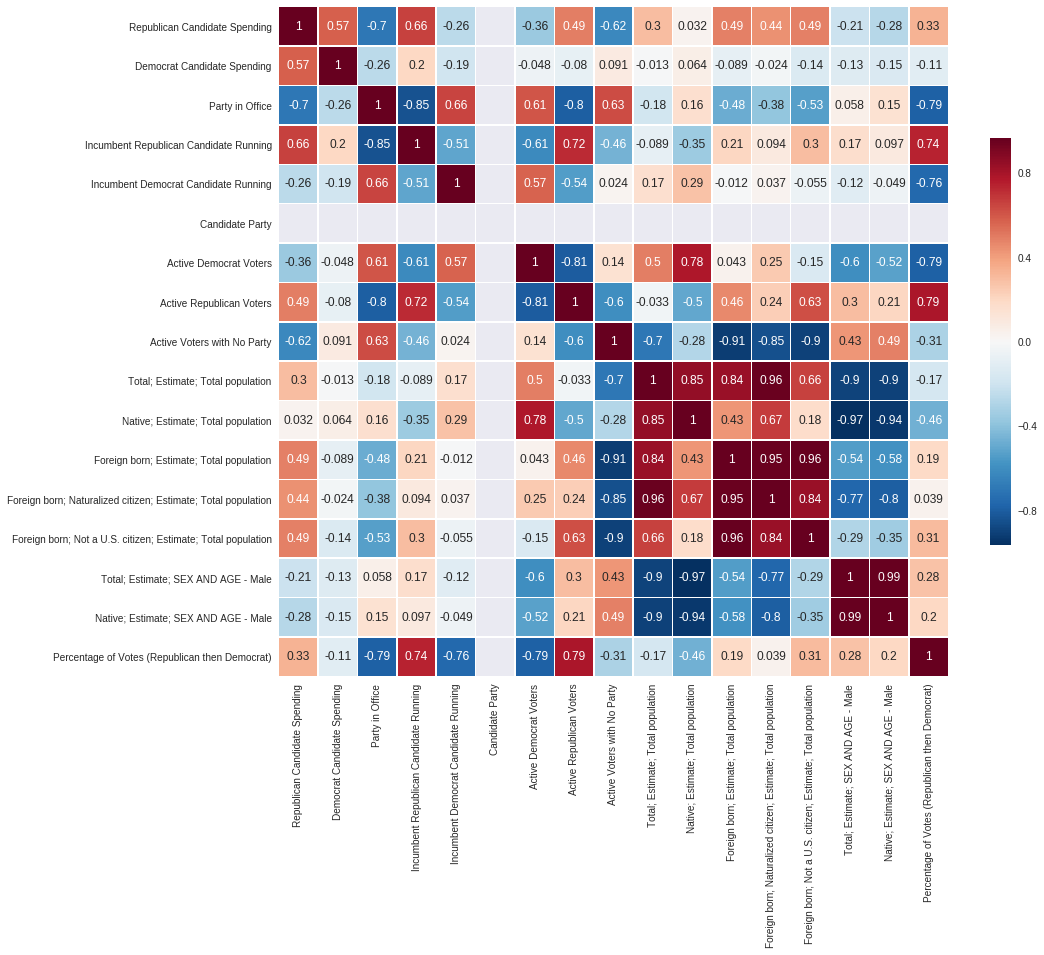

In [333]:
# ----- WARNING: This takes a pretty long time if you use a large number of features ----- #
# Plot correlation matrix
repub_corr = df_republican[['Republican Candidate Spending', 'Democrat Candidate Spending', 'Party in Office', 
                            'Incumbent Republican Candidate Running', 'Incumbent Democrat Candidate Running', 
                            'Candidate Party', 'Active Democrat Voters', 'Active Republican Voters', 
                            'Active Voters with No Party', 'Total; Estimate; Total population', 
                            'Native; Estimate; Total population', 'Foreign born; Estimate; Total population', 
                            'Foreign born; Naturalized citizen; Estimate; Total population', 
                            'Foreign born; Not a U.S. citizen; Estimate; Total population', 
                            'Total; Estimate; SEX AND AGE - Male', 'Native; Estimate; SEX AND AGE - Male',
                            'Percentage of Votes (Republican then Democrat)']].corr()

# Initialize matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Set custom colormap options
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation matrix as a heatmap with mask
sns.heatmap(repub_corr, vmax=.3, annot=True,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

plt.show()

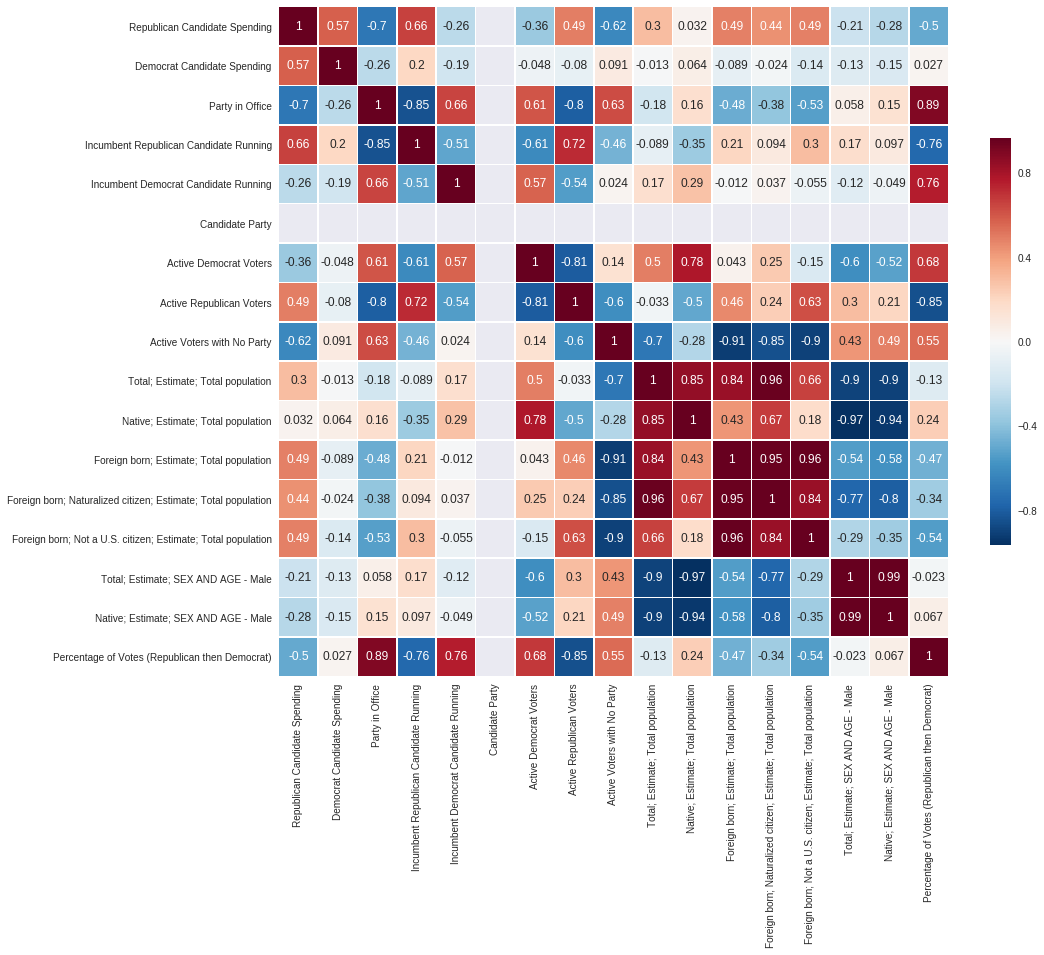

In [334]:
# ----- WARNING: This takes a pretty long time if you use a large number of features ----- #
# Plot correlation matrix
dem_corr = df_democrat[['Republican Candidate Spending', 'Democrat Candidate Spending', 'Party in Office', 
                        'Incumbent Republican Candidate Running', 'Incumbent Democrat Candidate Running', 
                        'Candidate Party', 'Active Democrat Voters', 'Active Republican Voters', 
                        'Active Voters with No Party', 'Total; Estimate; Total population', 
                        'Native; Estimate; Total population', 'Foreign born; Estimate; Total population', 
                        'Foreign born; Naturalized citizen; Estimate; Total population', 
                        'Foreign born; Not a U.S. citizen; Estimate; Total population', 
                        'Total; Estimate; SEX AND AGE - Male', 'Native; Estimate; SEX AND AGE - Male',
                        'Percentage of Votes (Republican then Democrat)']].corr()

# Initialize matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Set custom colormap options
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation matrix as a heatmap with mask
sns.heatmap(dem_corr, vmax=.3, annot=True,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

plt.show()

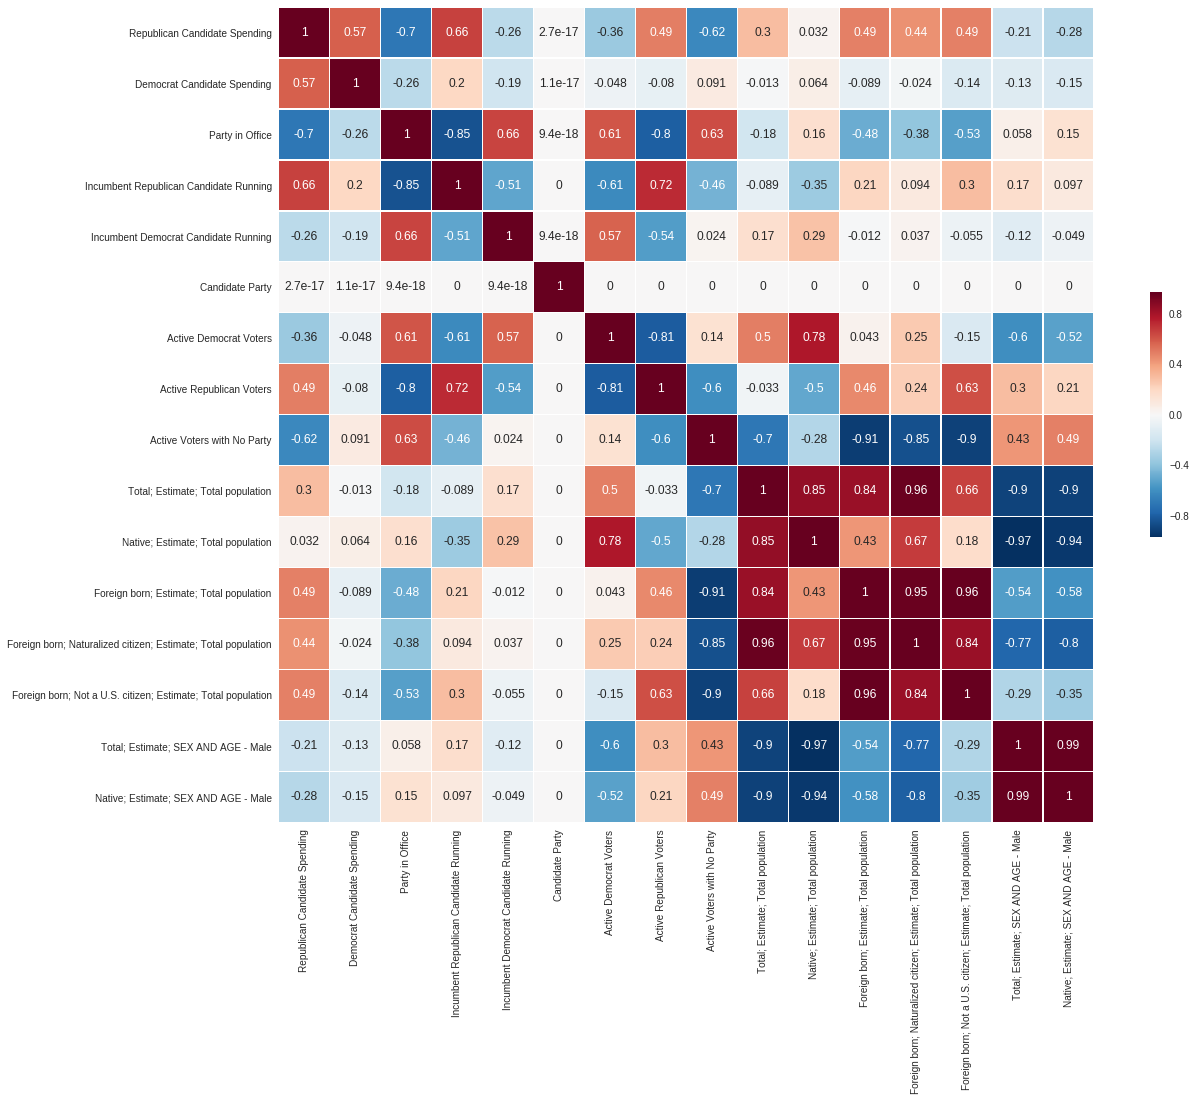

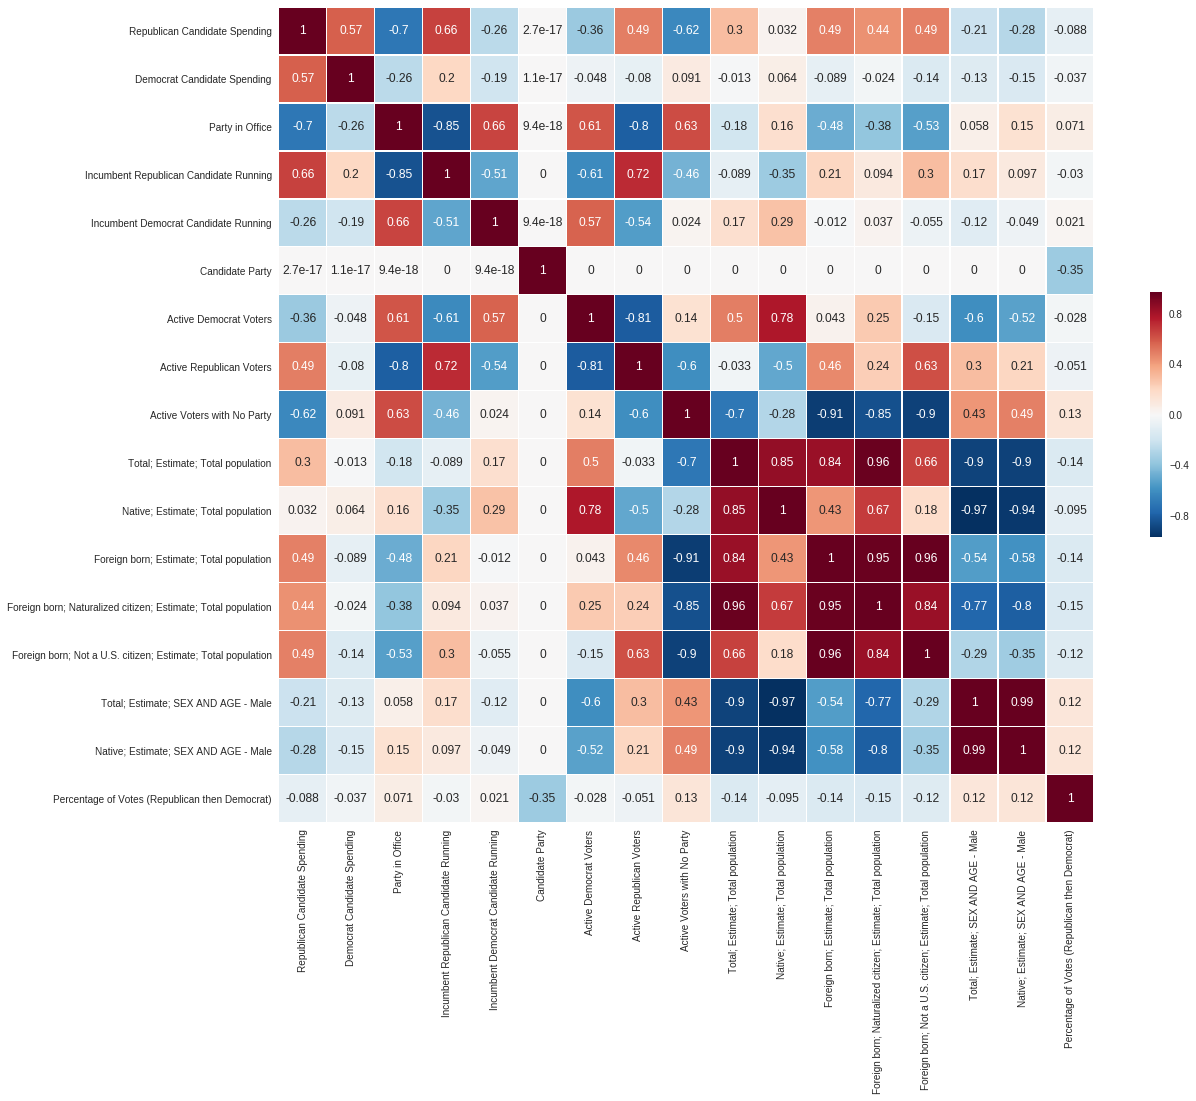

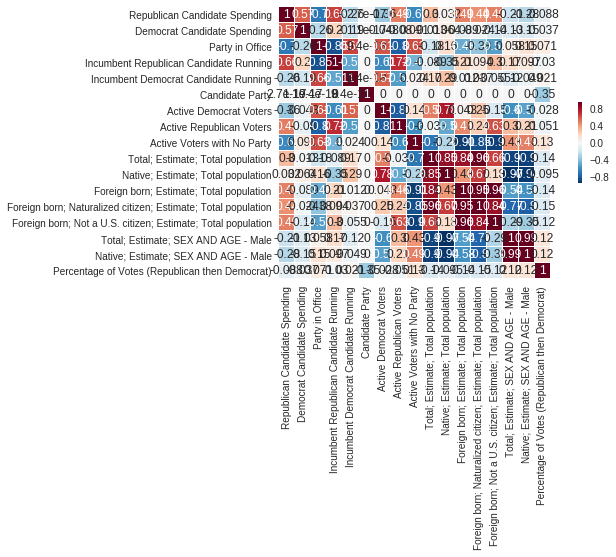

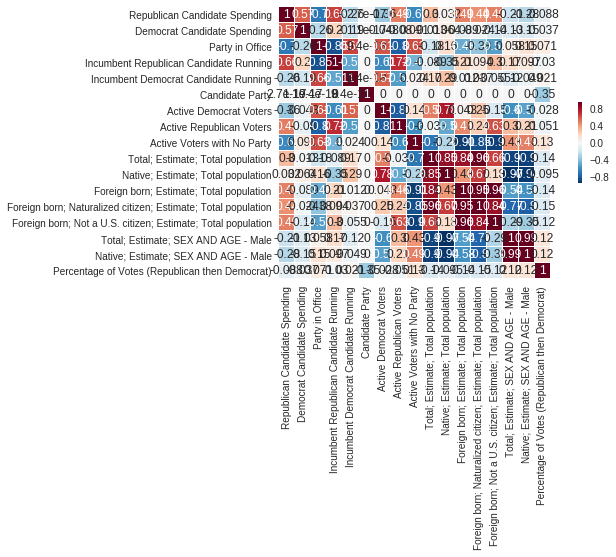

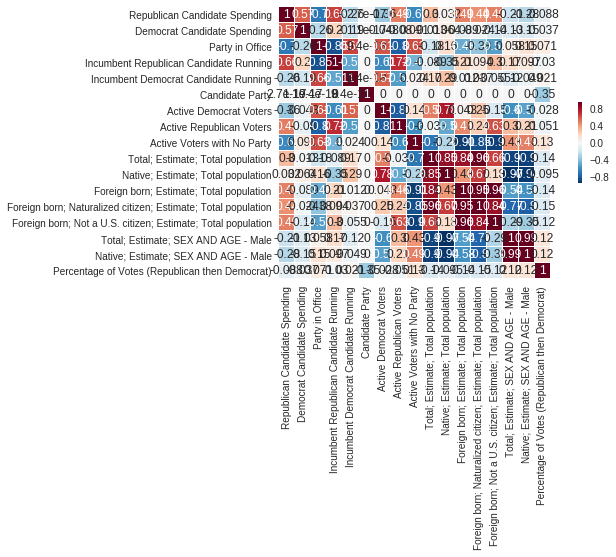

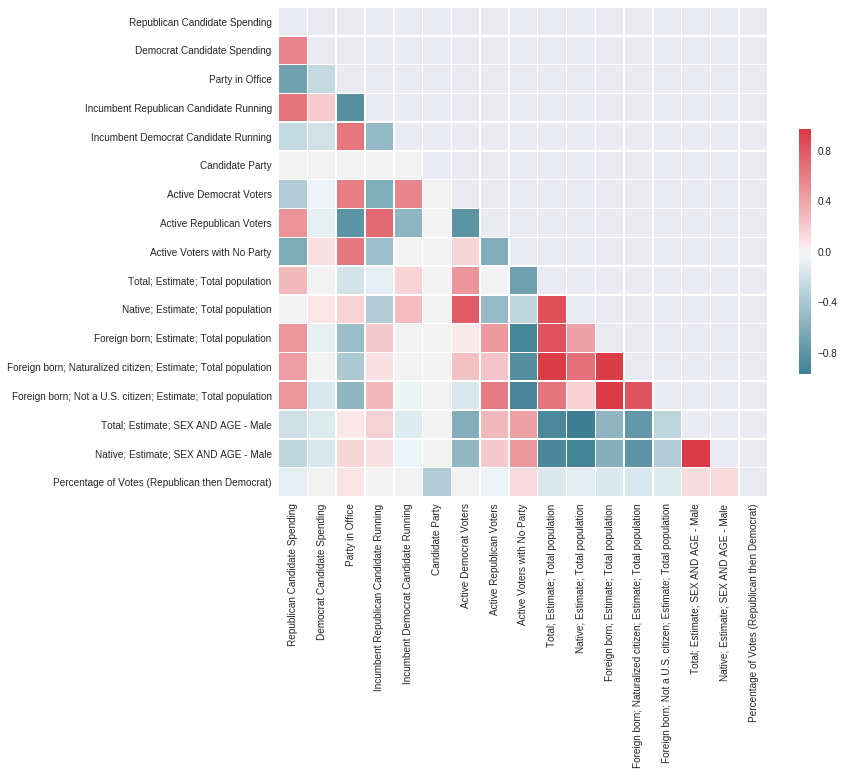

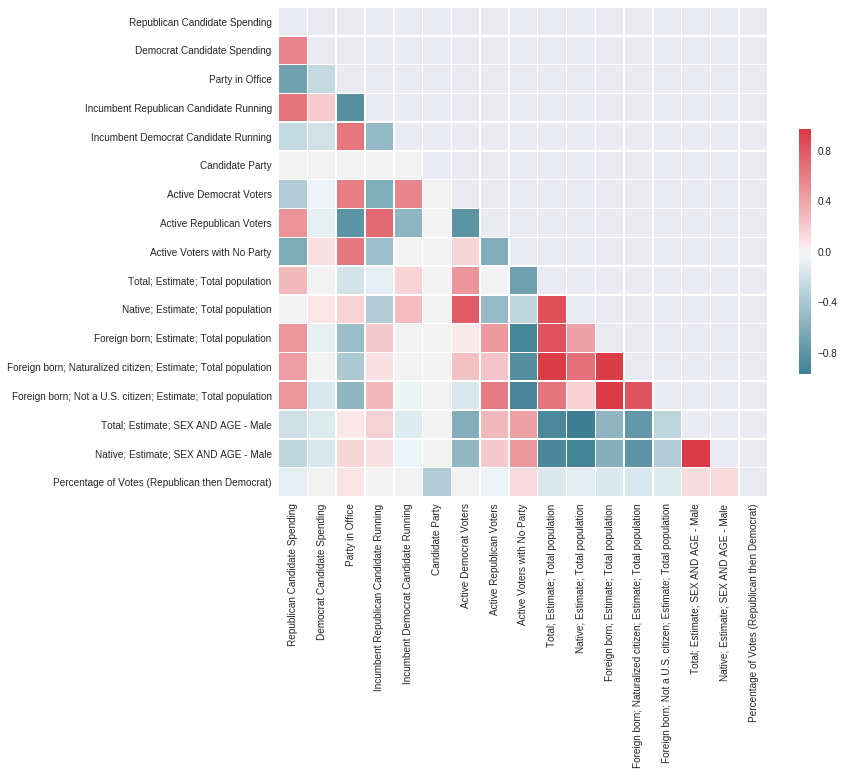

In [394]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Random Forest Classifier

In [212]:
# Create a random forest Classifier. 
#rf = RandomForestClassifier(n_estimators=10, random_state=43)

# Train the Classifier on our training data
#rf.fit(X_train, Y_train)

ValueError: Unknown label type: 'continuous'

In [20]:
# Make predictions on the testing set using our random forest
#prediction = rf.predict(X_test)

In [21]:
# Determine the absolute error
#abs_error = np.abs(prediction - Y_test)

# Return the percentage of correctly classified incomes
#print("Percentage of correctly classified incomes: %.2f." %(100*(1 - np.sum(abs_error)/Y_test.size)))

Percentage of correctly classified incomes: 84.86.


**Visualizing and Interpreting our Results**

In [22]:
# Create a plot of the importance of each feature
#plt.bar(np.arange(len(feature_list)), rf.feature_importances_);
#plt.xticks(np.arange(len(feature_list)), feature_list, rotation='vertical');

In [26]:
# Extract one tree from the random forest
#tree1 = rf.estimators_[5]

# Export the image to a dot file
#export_graphviz(tree1, out_file = 'tree.dot', feature_names = feature_list, rounded = True)

# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
#graph.write_png('tree.png')

**Classification Using a Support Vector Machine**

In [ ]:
# Initialize our SVM
our_SVM = svm.SVC()

# Fit our SVM
our_SVM.fit(X_train, Y_train)

# Score our SVM on set aside test data
normalized_test_data_SCORE = our_SVM.score(X_test, Y_test)

In [ ]:
# Print the percentage classified correctly for unnormalized and normalized data
print("The percentage of people correctly classified using 80/20 Train/Test Data:")
print("  Without normalization of input data :", 100 * test_data_SCORE)
print("  With normalization of input data    :", 100 * normalized_test_data_SCORE)

In [ ]:
# If you want to create an array of values for prediction you can use the following command
# ----- Perform predicition on set aside test data -----
Y_prediction = our_SVM.predict(X_test)